In [1]:
import json
from functools import partial

import pandas as pd
import pyproj
import numpy as np
import shapely.ops as ops
from tqdm import tqdm
from shapely.geometry import shape

import matplotlib.pyplot as plt
import mplleaflet

from city_conf import city_mappings

## Map data results

In [ ]:
def find_polygon_area(geojson):
    geom = shape(geojson)
    geom_area = ops.transform(
        partial(
            pyproj.transform,
            pyproj.Proj(init='EPSG:4326'),
            pyproj.Proj(
                proj='aea',
                lat_1=geom.bounds[1],
                lat_2=geom.bounds[3]
            )
        ),
        geom)
    return geom_area.area / 1e6

In [ ]:
experiment_name = "data/2023-01-10/"

city_records = []
for country_map in city_mappings:
    for city in city_mappings[country_map]:
        city_name = list(city.keys())[0]
        osm_id = city[city_name]["osm_id"]
        try:
            with open(f"{experiment_name}/results/{city_name}.json", "r") as f:
                city_record = json.load(f)

            with open(f"{experiment_name}/city_polygons/{city_name.lower()}_polygon.geojson") as f:
                city_polygon = json.load(f)

            city_record["osm_id"] = osm_id
            city_record["area_km2"] = find_polygon_area(city_polygon)
            city_records.append(city_record)
        except:
            continue

In [ ]:
df = pd.DataFrame(city_records)

In [ ]:
df

In [ ]:
city_records_with_decay = []
for country_map in city_mappings:
    for city in city_mappings[country_map]:
        city_name = list(city.keys())[0]
        osm_id = city[city_name]["osm_id"]
        try:
            with open(f"{experiment_name}/results/{city_name}_decay.json", "r") as f:
                city_record = json.load(f)

            with open(f"{experiment_name}/city_polygons/{city_name.lower()}_polygon.geojson") as f:
                city_polygon = json.load(f)

            city_record["osm_id"] = osm_id
            city_record["area_km2"] = find_polygon_area(city_polygon)
            city_records_with_decay.append(city_record)
        except:
            continue

In [ ]:
df_decay = pd.DataFrame(city_records_with_decay)

In [ ]:
df_decay

In [ ]:
df["overall_road_length"] = df["total_cycling_road_length"] + df["total_road_length"]
df_decay["overall_road_length"] = df_decay["total_cycling_road_length"] + df_decay["total_road_length"]

In [ ]:
df["cycle_road_share"] = df["total_cycling_road_length"] / df["overall_road_length"]
df_decay["cycle_road_share"] = df_decay["total_cycling_road_length"] / df_decay["overall_road_length"]

In [ ]:
df["cycle_track_share"] = df["total_cycle_track_length"] / df["overall_road_length"]
df_decay["cycle_track_share"] = df_decay["total_cycle_track_length"] / df_decay["overall_road_length"]

In [ ]:
df["cycle_lane_share"] = df["total_cycle_lane_length"] / df["overall_road_length"]
df_decay["cycle_lane_share"] = df_decay["total_cycle_lane_length"] / df_decay["overall_road_length"]

In [ ]:
df["segregated_cycle_track_share"] = df["total_segregated_cycle_track_length"] / df["overall_road_length"]
df_decay["segregated_cycle_track_share"] = df_decay["total_segregated_cycle_track_length"] / df_decay[
    "overall_road_length"]

In [ ]:
df["rank_cycle_road_share"] = df["cycle_road_share"].rank(ascending=False).astype(int)
df["rank_cycle_track_share"] = df["cycle_track_share"].rank(ascending=False).astype(int)
df["rank_segregated_cycle_track_share"] = df["segregated_cycle_track_share"].rank(ascending=False).astype(int)

In [ ]:
df_decay["rank_cycle_road_share"] = df_decay["cycle_road_share"].rank(ascending=False).astype(int)
df_decay["rank_cycle_track_share"] = df_decay["cycle_track_share"].rank(ascending=False).astype(int)
df_decay["rank_segregated_cycle_track_share"] = df_decay["segregated_cycle_track_share"].rank(ascending=False).astype(
    int)

In [ ]:
merged = df.merge(df_decay, on=["city_name", "osm_id", "area_km2"], suffixes=["", "_decayed"])

# merged["overall_score"] = merged["cycle_road_share_decayed"] * merged["cycle_track_share_decayed"] #* merged[
#     "segregated_cycle_track_share_decayed"]
# merged["overall_score"] = merged["cycle_road_share"] * merged["segregated_cycle_track_share"]
merged["overall_score"] = merged["cycle_road_share_decayed"]
merged["overall_rank"] = merged["overall_score"].rank(ascending=False).astype(int)

In [ ]:
merged["parking_per_km2"] = merged['parking_counter'] / merged["area_km2"]

In [ ]:
# merged["rank_diff"] = (merged["cycle_road_share_decayed"] - merged["cycle_road_share"]) / merged["cycle_road_share"]

In [ ]:
merged["rank_diff"] = merged["rank_cycle_road_share"] - merged["rank_cycle_road_share_decayed"]

In [ ]:
merged.sort_values("rank_diff")

In [ ]:
### Print for web

In [ ]:
final = merged[
    ["city_name",
     "osm_id",
     "area_km2",
     "total_road_length",
     "total_cycling_road_length",
     "cycle_road_share",
     "cycle_track_share",
     "cycle_lane_share",
     "segregated_cycle_track_share",
     "cycle_road_share_decayed",
     "cycle_track_share_decayed",
     "segregated_cycle_track_share_decayed",
     "parking_per_km2",
     "overall_rank"]].round(3).rename(columns={
    "city_name": "City name",
    "osm_id": "OSM id",
    "area_km2": "Area (km2)",
    "total_road_length": "Navigable road length (km)",
    "total_cycling_road_length": "Navigable bike road length (km)",
    "cycle_road_share": "Cycle road share",
    "cycle_track_share": "Cycle track share",
    "cycle_lane_share": "Cycle lane share",
    "segregated_cycle_track_share": "Segregated track share",
    "cycle_road_share_decayed": "Cycle road share (weighted)",
    "cycle_track_share_decayed": "Cycle track share (weighted)",
    "segregated_cycle_track_share_decayed": "Segregated track share (weighted)",
    "parking_per_km2": "Parking spaces (per km2)",
    "overall_rank": "Rank"
})

In [ ]:
final_for_blog = merged[
    ["city_name",
     "osm_id",
     "area_km2",
     "total_road_length",
#      "total_cycling_road_length",
     "cycle_road_share_decayed",
#      "cycle_track_share",
#      "cycle_lane_share",
#      "segregated_cycle_track_share",
#      "cycle_road_share_decayed",
#      "cycle_track_share_decayed",
#      "segregated_cycle_track_share_decayed",
#      "parking_per_km2",
     "overall_rank"]
].round(3).rename(columns={"city_name": "City name", "osm_id": "OSM id", "area_km2": "Area (km2)", "total_road_length": "Navigable road length (km)", "cycle_road_share_decayed": "Cycle road share (weighted)", "overall_rank": "Rank"})

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
final.sort_values("Rank", ascending=True)

In [ ]:
# print(final.to_html(index=False))
with open("table.cs.html", "wt") as fout:
    fout.write(final.sort_values("Rank", ascending=True).to_html(index=False))
    
final.sort_values("Rank", ascending=True).to_csv("table.cs.csv", index=False)

In [ ]:
print(final_for_blog.sort_values("Rank", ascending=True).head(30).to_markdown(index=False))

In [ ]:
def generate_html(dataframe: pd.DataFrame):
    # get the table HTML from the dataframe
    table_html = dataframe.to_html(table_id="table")
    # construct the complete HTML with jQuery Data tables
    # You can disable paging or enable y scrolling on lines 20 and 21 respectively
    html = f"""
    <html>
    <header>
        <link href="https://cdn.datatables.net/1.11.5/css/jquery.dataTables.min.css" rel="stylesheet">
    </header>
    <body>
    {table_html}
    <script src="https://code.jquery.com/jquery-3.6.0.slim.min.js" integrity="sha256-u7e5khyithlIdTpu22PHhENmPcRdFiHRjhAuHcs05RI=" crossorigin="anonymous"></script>
    <script type="text/javascript" src="https://cdn.datatables.net/1.11.5/js/jquery.dataTables.min.js"></script>
    <script>
        $(document).ready( function () {{
            $('#table').DataTable({{
                // paging: false,    
                // scrollY: 400,
            }});
        }});
    </script>
    </body>
    </html>
    """
    # return the html
    return html

In [ ]:
html = generate_html(final.sort_values("Rank", ascending=True))
# write the HTML content to an HTML file
with open("table.cs.sortable.html", "wt") as fout:
    fout.write(html)

## Road network

In [2]:
pd.set_option('display.max_rows', 100)

NameError: name 'pd' is not defined

In [152]:
from pyrosm import OSM
import pickle
import matplotlib.pyplot as plt
import tqdm
import pandas as pd
import json

In [116]:
osm_city = "Brno"
experiment_name = "data/2023-01-10"
city_data = json.load(open("config/city_conf_czechia.json"))

In [117]:
filepath = f'{experiment_name}/extracted_maps/{osm_city}.pbf'
osm = OSM(filepath)
nodes_driving, edges_driving = osm.get_network(nodes=True, network_type="cycling")
nodes_all, edges_all = osm.get_network(nodes=True, network_type="all")
drive_net = osm.get_network(network_type="cycling")

In [118]:
with open(f"{experiment_name}/results/{osm_city}_way_ids.pkl", "rb") as f:
     way_ids = pickle.load(f)

In [119]:
subset = drive_net[drive_net["id"].isin(list(way_ids.keys()))]

In [120]:
subset["length"].sum() / drive_net["length"].sum()

0.02767495955673013

In [121]:
lanes = subset[subset["highway"] != "cycleway"]

In [122]:
segregated_lanes = subset[subset["highway"] != "cycleway"]

In [123]:
subset.shape

(552, 37)

In [124]:
subset["length"].sum()

85639.0

geopandas.geodataframe.GeoDataFrame

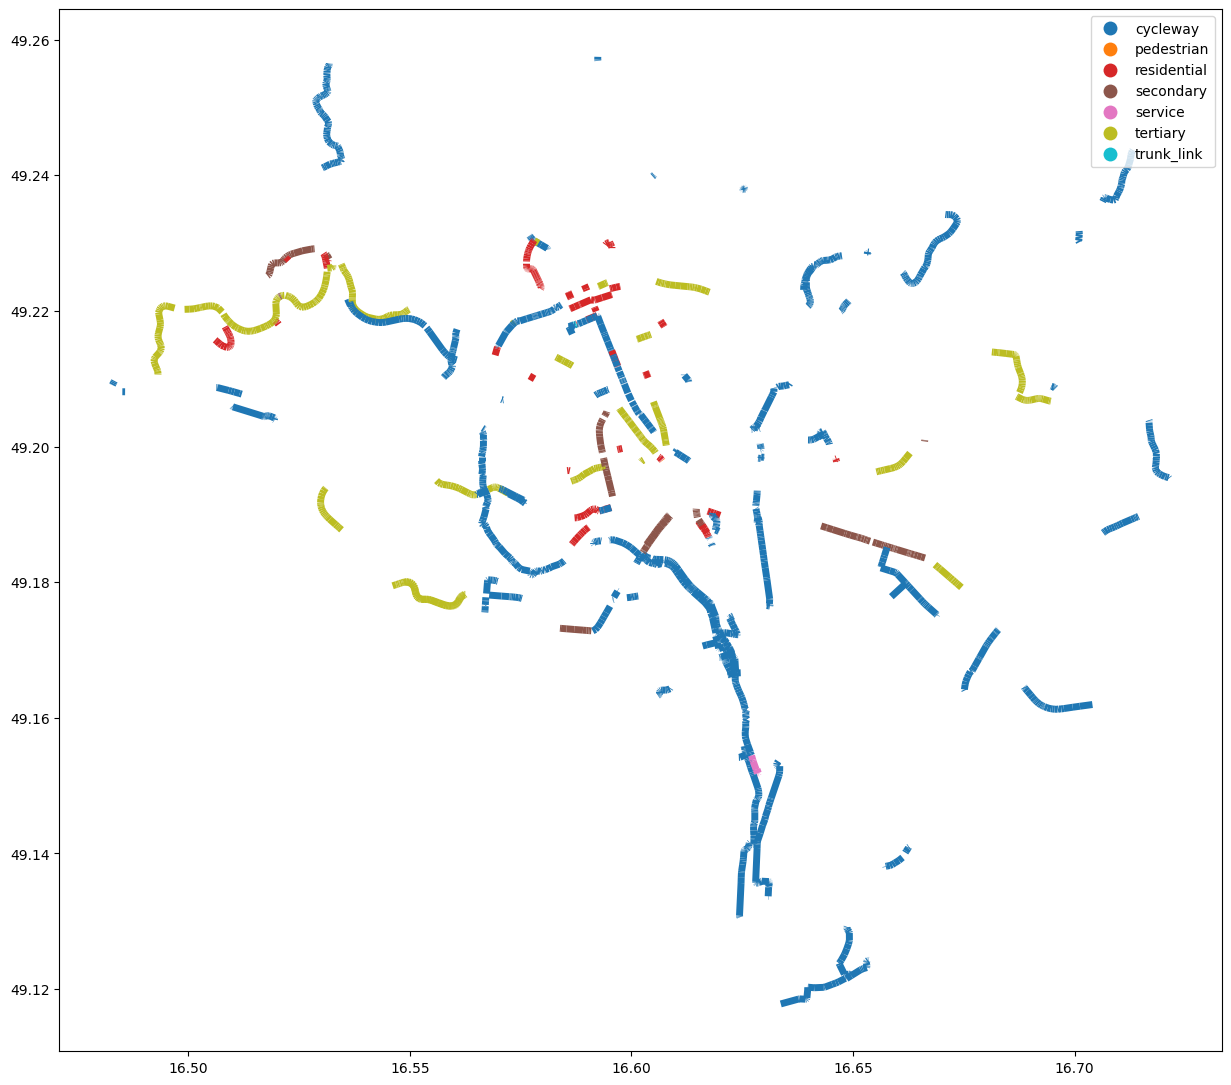

In [160]:
foo = subset.plot(figsize=(15, 15), column="highway", legend=True, linewidth=5)
# and save
plt.savefig('world.png', dpi=300)
type(subset)

In [126]:
m = subset.explore()
m.save(f"{osm_city}.html")
m

In [127]:
m = lanes.explore()
m.save(f"{osm_city}_lanes.html")
m

In [128]:
paths = subset[subset["highway"].isin(["path", "footway"])]

In [129]:
expanded = paths.explode()

/tmp/ipykernel_94125/3867208203.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  expanded = paths.explode()


In [130]:
way_to_coef = {}
i = 0

for w in way_ids:
    coef = way_ids[w]["weighted_distance"] / way_ids[w]["raw_distance"]
    way_to_coef[w] = coef

In [131]:
way_ids

{4020549: {'raw_distance': 18.57729552706489,
  'dist_from_centr': 0.3825834793596624,
  'weighted_distance': 18.57729552706489},
 4020558: {'raw_distance': 500.7280292080454,
  'dist_from_centr': 2.3091622898637505,
  'weighted_distance': 368.18348986459426},
 4043707: {'raw_distance': 13.347318143215883,
  'dist_from_centr': 2.9191659646822927,
  'weighted_distance': 7.78370471998057},
 4044027: {'raw_distance': 78.1667953311996,
  'dist_from_centr': 3.2161259771984883,
  'weighted_distance': 40.71990641200068},
 4083947: {'raw_distance': 144.18138444694142,
  'dist_from_centr': 1.9683555992736255,
  'weighted_distance': 120.6745187336016},
 4228210: {'raw_distance': 11.01729985219035,
  'dist_from_centr': 0.7926000031777485,
  'weighted_distance': 11.01729985219035},
 4228211: {'raw_distance': 6.303680922032564,
  'dist_from_centr': 0.7328367710000536,
  'weighted_distance': 6.303680922032564},
 4315696: {'raw_distance': 12.811277454004282,
  'dist_from_centr': 0.7760059499782844,
 

In [132]:
way_to_coef

{4020549: 1.0,
 4020558: 0.7352963452972976,
 4043707: 0.5831661938722003,
 4044027: 0.5209361115479643,
 4083947: 0.836963240410621,
 4228210: 1.0,
 4228211: 1.0,
 4315696: 1.0,
 4318376: 0.6340943176106342,
 4318380: 0.20003131634279314,
 4332680: 1.0,
 4532070: 0.1282561110889094,
 4674360: 0.1109031243029826,
 5050956: 0.7080871044086171,
 5050957: 0.6836638420926634,
 5586928: 1.0,
 5776738: 0.4694139834703681,
 7656032: 1.0,
 8134289: 0.9054062537193033,
 8315214: 0.1135458647590526,
 8440824: 0.34236685998592803,
 8440825: 0.34490752406948894,
 8585080: 0.41841173927237674,
 10115505: 0.4538299806775243,
 15504097: 0.5285746565271469,
 15667919: 0.5541905625087769,
 15667936: 0.5394823973100237,
 17416326: 0.1679609817743101,
 17416327: 0.16925645646238618,
 17416349: 1.0,
 17416352: 1.0,
 25800128: 0.4220598639262723,
 26304171: 0.4348850819980094,
 26338439: 0.18589760200524366,
 26338514: 0.14684422147920417,
 26447974: 0.23448547864449198,
 26447992: 0.6312324364873129,
 266

In [133]:
# way_ids_for_viz = [24773942, 162582750, 65180197, 214469336, 91896352, 213878646]
way_ids_for_viz = list(way_ids.keys())

In [134]:
for w in way_ids_for_viz:
     print(w, way_to_coef[w])

4020549 1.0
4020558 0.7352963452972976
4043707 0.5831661938722003
4044027 0.5209361115479643
4083947 0.836963240410621
4228210 1.0
4228211 1.0
4315696 1.0
4318376 0.6340943176106342
4318380 0.20003131634279314
4332680 1.0
4532070 0.1282561110889094
4674360 0.1109031243029826
5050956 0.7080871044086171
5050957 0.6836638420926634
5586928 1.0
5776738 0.4694139834703681
7656032 1.0
8134289 0.9054062537193033
8315214 0.1135458647590526
8440824 0.34236685998592803
8440825 0.34490752406948894
8585080 0.41841173927237674
10115505 0.4538299806775243
15504097 0.5285746565271469
15667919 0.5541905625087769
15667936 0.5394823973100237
17416326 0.1679609817743101
17416327 0.16925645646238618
17416349 1.0
17416352 1.0
25800128 0.4220598639262723
26304171 0.4348850819980094
26338439 0.18589760200524366
26338514 0.14684422147920417
26447974 0.23448547864449198
26447992 0.6312324364873129
26627026 0.12026780793615252
26984203 0.3451169231099382
27062765 0.4288805993809119
27062770 0.432158442947033
270

In [135]:
cycle_roads = drive_net[drive_net.id.isin(way_ids_for_viz)]

In [136]:
expanded = cycle_roads.explode()

/tmp/ipykernel_94125/4065863413.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  expanded = cycle_roads.explode()


In [137]:
way_to_coord = {}

In [138]:
lngs = []
lats = []
ids = []
for geom, way_id in zip(expanded["geometry"], expanded["id"]):
    (start_lng, start_lat), (end_lng, end_lat) = geom.coords
    if way_id not in way_to_coord:
        way_to_coord[way_id] = (start_lat, start_lng)
    lngs.append((start_lng, end_lng))
    lats.append((start_lat, end_lat))
    ids.append(way_id)

In [139]:
from shapely.geometry import Point, shape, Polygon, MultiPolygon
from functools import partial
import random
import pyproj
from shapely.ops import transform
import matplotlib.pyplot as plt

In [140]:
proj_wgs84 = pyproj.Proj('+proj=longlat +datum=WGS84')

def geodesic_point_buffer(lat, lon, km):
    # Azimuthal equidistant projection
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    project = partial(
        pyproj.transform,
        pyproj.Proj(aeqd_proj.format(lat=lat, lon=lon)),
        proj_wgs84)
    buf = Point(0, 0).buffer(km * 1000)  # distance in metres
    return transform(project, buf).exterior.coords[:]

def create_circle_around_coord(lat, lon, km):
    b = geodesic_point_buffer(lat, lon, km)
    circle_lats = [x[1] for x in b]
    circle_lngs = [x[0] for x in b]
    return circle_lats, circle_lngs, b

In [141]:
# city_centroid = (13.3746469, 49.7492219)
city_centroid = city_data[list(city_data.keys())[0]]

for c in city_centroid:
    # if c is the same as dict key
    if list(c.keys())[0] == osm_city:
        city_centroid = c[osm_city]["centre"]
        break
print(city_centroid)
circle = create_circle_around_coord(city_centroid[0], city_centroid[1], 8)

[49.19232, 16.60883]


/home/dan/pex/venv3.10/lib/python3.10/site-packages/shapely/ops.py:305: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  zip(*func(*zip(*geom.exterior.coords))))


100%|██████████| 3108/3108 [00:01<00:00, 2002.67it/s]


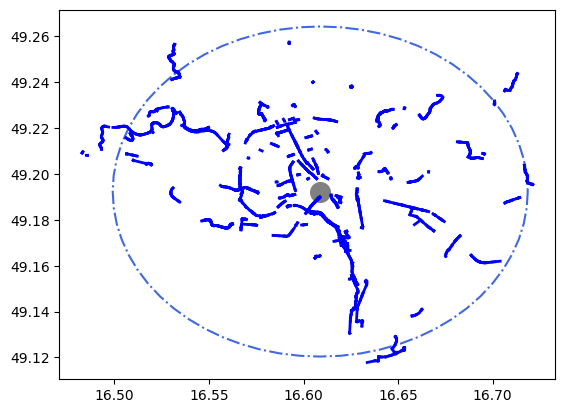

In [142]:
plt.scatter(city_centroid[1], city_centroid[0], color='gray', marker='o', s=200)
plt.plot(circle[1], circle[0], '-.', color="royalblue")
for i in tqdm.tqdm(range(len(lngs))):
#     color = str(color_map(way_to_coef[ids[i]]))
     color = "blue"
     plt.plot(lngs[i], lats[i], linewidth=2.0, color=color)
# mplleaflet.show(tiles="cartodb_positron")
# mplleaflet.show()
plt.show()

## European map

In [ ]:
from city_conf import city_mappings

In [ ]:
city_centres = {}
for country in city_mappings:
    for city in city_mappings[country]:
        city_name = list(city.keys())[0]
        city_centre = city[city_name]['centre']
        city_centres[city_name] = city_centre

In [ ]:
from bs4 import BeautifulSoup
import requests

In [ ]:
html = "https://en.wikipedia.org/wiki/List_of_cities_in_the_European_Union_by_population_within_city_limits"

In [ ]:
parsed_html = BeautifulSoup(requests.get(html).text)

In [ ]:
table = parsed_html.find('table')

In [ ]:
df = pd.read_html(html)[0]

In [ ]:
cities = []
pops = []
shares = []

for city_name, pop in zip(df["City"], df["Officialpopulation"]):
    if (city_name in city_centres) and (city_name in final["City name"].values):
        cities.append(city_name)
        pops.append(np.log(pop))
        shares.append(final[final["City name"] == city_name]["Cycle road share (weighted)"].iloc[0])

In [ ]:
plt.scatter(pops, shares)
m, b = np.polyfit(np.array(pops), np.array(shares), 1)
plt.plot(pops, m*np.array(pops) + b, '--', color='blue')
plt.xlabel("Log(population)")
plt.ylabel("Cycle road share (weighted)")
plt.show()

In [ ]:
np.exp(13)

In [ ]:
lats = [city_centres[c][0] for c in city_centres]
lngs = [city_centres[c][1] for c in city_centres]
shares = []
for city_name in city_centres:
    shares.append(final[final["city_name"] == city_name]["cycle_road_share_decayed"].iloc[0])
    
plt.scatter(lngs, lats, s=np.array(shares)*3000, alpha=0.6)
mplleaflet.show()